In [1]:
!hostname

fedora


In [2]:
import  torch, torchvision, torchaudio
print(f"Torch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}\nTorchaudio version: {torchaudio.__version__}")
print("CUDA available:", torch.cuda.is_available())
assert torch.cuda.is_available()

from    torchvision import datasets, transforms
from    torch.utils.data import DataLoader, Subset
import  torch.optim as optim
import  torch.nn as nn
import  torch.nn.functional as F
from    tqdm import tqdm
from    sklearn.metrics import confusion_matrix, classification_report
from    sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from    matplotlib.colors import LogNorm
import  seaborn as sns
import  numpy as np
import  mediapipe as mp
from    PIL import Image
import  os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Torchaudio version: 2.6.0+cu124
CUDA available: True
Using device: cuda


In [3]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # These are standardization values from ImageNet
                         std=[0.229, 0.224, 0.225])
])

# Change this before running:
dataset_path = r"dataset" # Either use 'dataset' or 'dataset_small' 

dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
targets = np.array([label for _, label in dataset.samples])

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
               'S', 'T', 'U', 'V', 'W', 'X', 'Y'] \
            if "small" not in dataset_path else ['A', 'B']

# Split the data
train_idx, test_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=123456
)

train_data = Subset(dataset, train_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64)

In [4]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=16):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) # 128x128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # 64x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # 32x32

        self.fc1 = nn.Linear(128 * 32 * 32, 256) # 131072 inputs
        self.fc2 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNNClassifier(num_classes=len(train_data.dataset.classes))


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def plot_confusion_matrix(model, data_loader, epoch, class_names):
    """Evaluate model and plot a log-scaled confusion matrix with annotations."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    # Avoid log(0) by adding 1 to empty cells
    cm_display = cm + 1

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        cm_display,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        norm=LogNorm(),       
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={"label": "Log-scaled frequency"}
    )

    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title(f"Confusion Matrix (Log Scale) — Epoch {epoch+1}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

Using device: cuda


Epoch 1/10 — avg loss: 0.8710


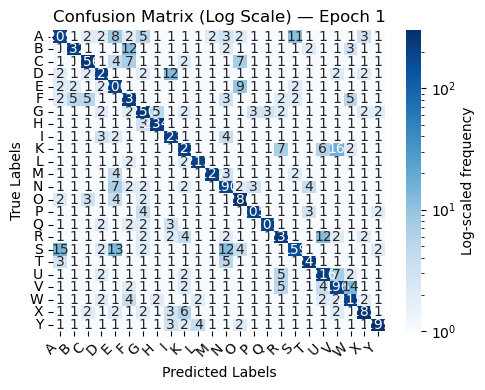

Epoch 2/10 — avg loss: 0.3330


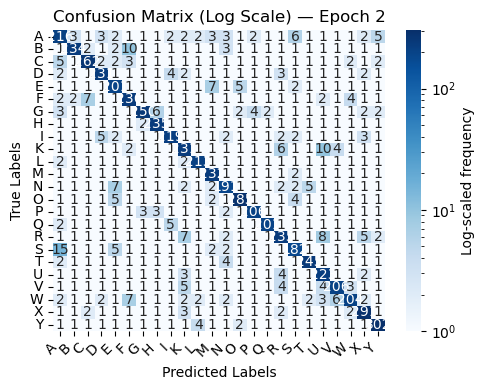

Epoch 3/10 — avg loss: 0.2567


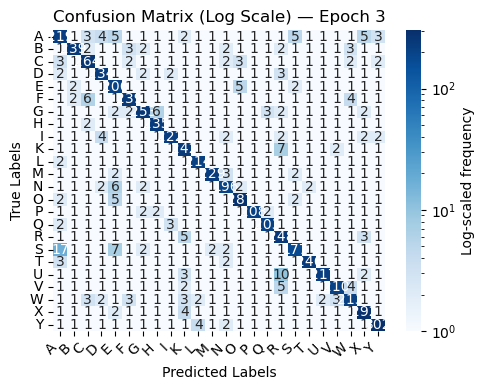

Epoch 4/10 — avg loss: 0.2085


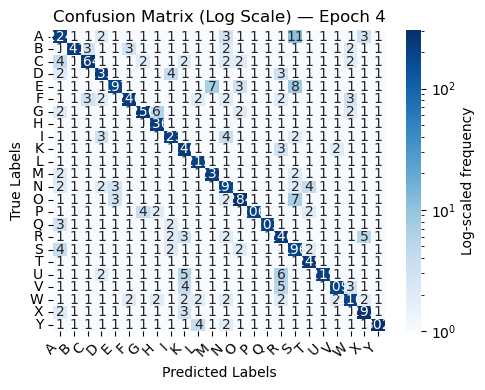

Epoch 5/10 — avg loss: 0.1854


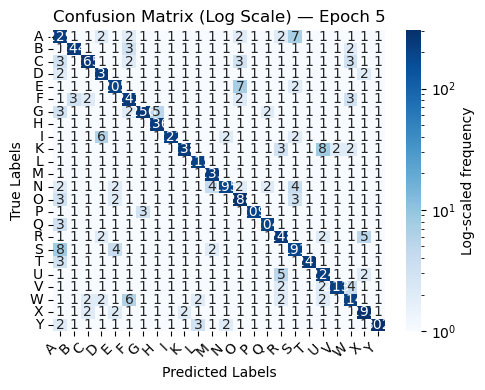

Epoch 6/10 — avg loss: 0.1612


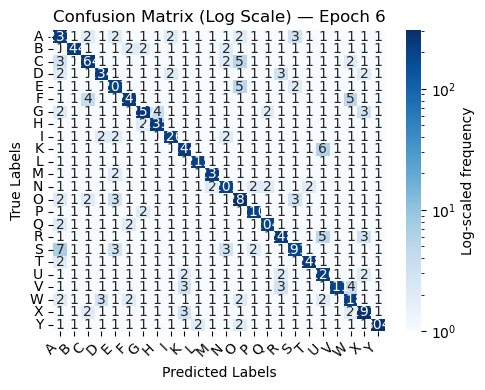

Epoch 7/10 — avg loss: 0.1481


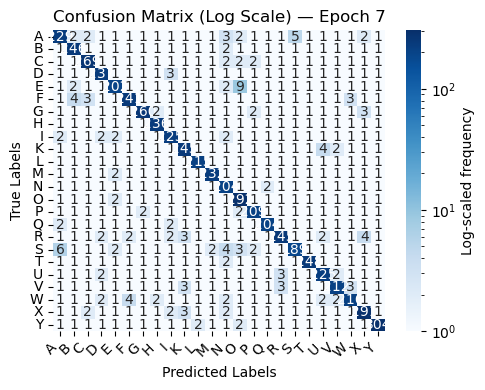

Epoch 8/10 — avg loss: 0.1311


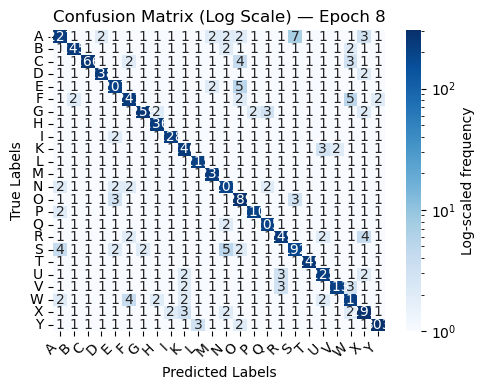

Epoch 9/10 — avg loss: 0.1222


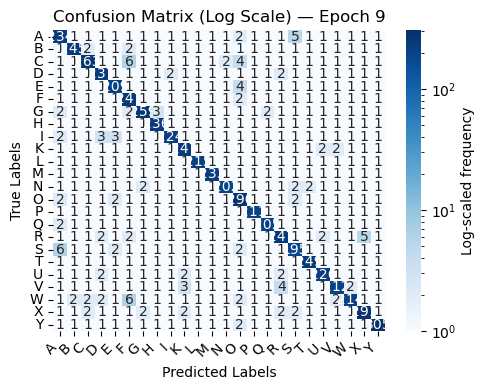

Epoch 10/10 — avg loss: 0.1166


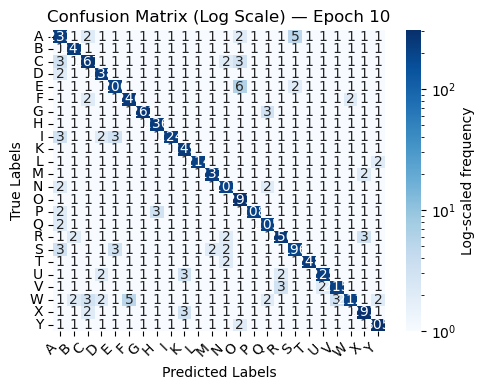

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — avg loss: {avg_loss:.4f}")

    # Plot confusion matrix after each epoch
    plot_confusion_matrix(model, val_loader, epoch, class_names=train_data.dataset.classes)

In [9]:
os.makedirs("models", exist_ok=True)
torch.save(model, f"models/asl_model{'' if dataset_path == r'dataset' else '_small'}.pth")

In [10]:
# Evaluate model on validation/test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = val_loader.dataset.dataset.classes

# Generate the report
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=3
)

print(report)

              precision    recall  f1-score   support

           A      0.967     0.975     0.971       238
           B      0.992     1.000     0.996       246
           C      0.993     0.982     0.987       271
           D      0.988     1.000     0.994       238
           E      0.977     0.986     0.981       211
           F      0.972     0.984     0.978       247
           G      0.996     0.989     0.992       263
           H      1.000     1.000     1.000       235
           I      1.000     0.978     0.989       228
           K      0.969     1.000     0.984       248
           L      1.000     1.000     1.000       214
           M      1.000     1.000     1.000       232
           N      0.971     0.985     0.978       204
           O      0.983     0.990     0.986       292
           P      1.000     0.990     0.995       210
           Q      0.972     1.000     0.986       205
           R      0.980     0.964     0.972       253
           S      0.970    